In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sim
import util
import torch
from IPython.display import clear_output
from models import GibbsLDA, PyroLDA
from pyro.distributions import Dirichlet, Categorical
from tqdm import tqdm

clear_output()

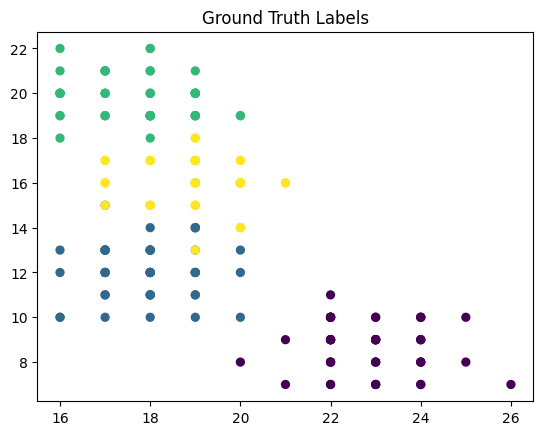

In [31]:
N_SAMPLES = 200
N_FEATURES = 100
N_TOPICS = 4
SCALE = 1
DISCRETIZE = True
SHUFFLE = True

if DISCRETIZE:
    X, X_labels, vocab = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
else:
    X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

Score: 0.87


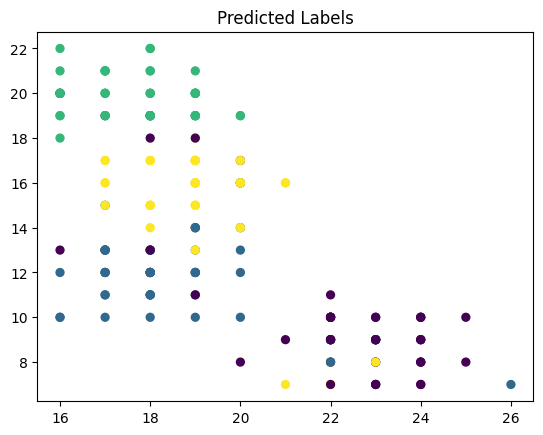

In [32]:
N_STEPS = 100

model = GibbsLDA(N_TOPICS).fit(torch.tensor(X), N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

In [29]:
vocab_size

40

In [30]:
X.shape

(200, 100)

In [33]:
N_STEPS = 100

vocab_size = np.unique(X).shape[0]
model = PyroLDA(N_TOPICS, vocab_size, batch_size=100).fit(torch.tensor(X.T), N_STEPS, 1e-1)
Y_labels, score = util.evaluate(X_labels, model.transform())
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Model and guide shapes disagree at site 'topic_words': torch.Size([4, 40]) vs torch.Size([4, 44])

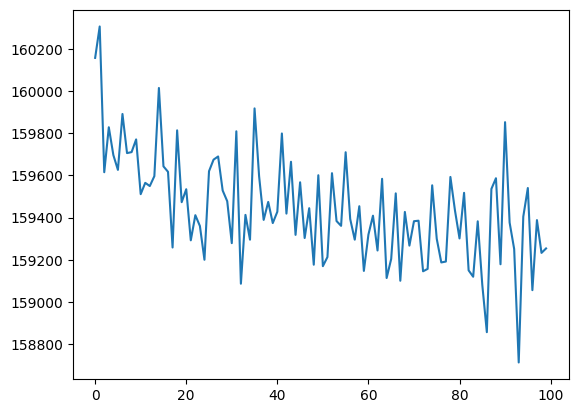

In [17]:
y = model.loss_log_
x = np.arange(len(y))
plt.plot(x, y);